In [11]:
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance

import matplotlib.pyplot as plt
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord
import astropy.coordinates as astro_coord
import astropy.units as u
from tqdm import tqdm
from popsims.galaxy import Disk, Halo, GalacticComponent
import popsims
from gala.units import UnitSystem

plot_style()

path_plot = '/users/caganze/research/stellarstreams/figures/'
path_data= '/users/caganze/research/stellarstreams/data/stream/'

#coords standards
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')

#unit system
usys = galactic

#global potential
disk=gp.MiyamotoNagaiPotential(6.9e10*u.Msun, 6.5*u.kpc, 0.26*u.kpc,units=  usys)
halo=gp.NFWPotential.from_M200_c(0.7e12*u.Msun, 10**1.5, units=usys)
bulge=gp.HernquistPotential(3.4e10*u.Msun, 0.7*u.kpc, units=  usys)

#pot= gp.CCompositePotential(disk=disk, bulge=bulge, halo=halo)
pot=gp.MilkyWayPotential(units=usys)
H = gp.Hamiltonian(pot)

#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([8.4, 251.8, 8.4]*u.km/u.s)
galcen_frame = astro_coord.Galactocentric(galcen_distance=8.275*u.kpc, galcen_v_sun=v_sun)

#palomar 5 present day coordinates
pal5_c = astro_coord.SkyCoord(ra=229.022*u.degree, dec= -0.112*u.degree,#vasiliev 2019
                   distance=20.6*u.kpc,#APW 2019
                   pm_ra_cosdec= -2.736*u.mas/u.yr, #vasiliev 2019
                   pm_dec=-2.646*u.mas/u.yr, #vasiliev 2019
                   radial_velocity= -58.60*u.km/u.s)#vasiliev 2019

cg= pal5_c.transform_to(galcen_frame)

In [10]:
gp.NFWPotential.

gala.potential.potential.builtin.cybuiltin.NFWPotential

In [2]:
def get_cyl_rotation(site_at_impact_w0): #borrowed from Adrian Price-Whelan's streampunch github repo
    L = site_at_impact_w0.angular_momentum()
    v = site_at_impact_w0.v_xyz

    new_z = v / np.linalg.norm(v, axis=0)
    new_x = L / np.linalg.norm(L, axis=0)
    new_y = -np.cross(new_x, new_z)
    R = np.stack((new_x, new_y, new_z))
    return R

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont

def rotate(x, y, ang):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],\
       [np.sin(ang), np.cos(ang)]]
    
    c=(0, 0)
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 

def evolve_orbits_only_as_null(st_coord, time_dict):
    #evolve stream and nbody for a short period without releasing any stars
    particle_pot = [ [gp.NullPotential(units=usys)] * st_coord.shape[0]][0]
    nbody = gd.DirectNBody(st_coord, particle_pot, external_potential=pot, save_all=True, units=  usys)
    return  nbody.integrate_orbit(**time_dict)

def evolve_stream_with_subhalo_orbits_only(st_coord, subh_coord, subh_pot, time_dict):
    
    particle_pot = [ [gp.NullPotential(units=usys)] * st_coord.shape[0]][0]
    particle_pot.append(subh_pot)
    
    xyz=list(st_coord.xyz.value.T)
    xyz.append( subh_coord.xyz.value)
    
    v_xyz=list(st_coord.v_xyz.value.T)
    v_xyz.append( subh_coord.v_xyz.value)
    
    xyz=np.array(xyz)
    v_xyz=np.array(v_xyz)
    
    tot_coord=gd.PhaseSpacePosition(pos=xyz.T*st_coord.xyz.unit, 
                                   vel=v_xyz.T*st_coord.v_xyz.unit)
  
                                    

    
    nbody = gd.DirectNBody(  tot_coord,  particle_pot , external_potential=pot, save_all=True, units=  usys)
    return  nbody.integrate_orbit(**time_dict)


def get_perturber_w0_at_impact(site_at_impact_w0, psi, v_rho, v_z, vpsi):
    # Get the rotation matrix to rotate from Galactocentric to cylindrical
    # impact coordinates at the impact site along the stream
    R = get_cyl_rotation(site_at_impact_w0)

    psi, v_rho, v_z, vpsi =  psi * u.rad, v_rho*u.km/u.s,  v_z * u.km/u.s, vpsi * u.rad/u.s
    # Define the position of the perturber at the time of impact in the
    # cylindrical impact coordinates:
    perturber_pos = astro_coord.CylindricalRepresentation(rho=0*u.kpc, 
                                                    phi=psi,
                                                    z=0*u.kpc) 

    # Define the velocity in the cylindrical impact coordinates:
    #maybe we want this to have the same vz as the stream?
    perturber_vel = astro_coord.CylindricalDifferential(d_rho=v_rho,d_phi=vpsi,d_z=v_z)

    # Transform from the cylindrical impact coordinates to Galactocentric
    perturber_rep = perturber_pos.with_differentials(perturber_vel)
    perturber_rep = perturber_rep.represent_as(astro_coord.CartesianRepresentation, astro_coord.CartesianDifferential)
    perturber_rep = perturber_rep.transform(R.T)

    pos = perturber_rep.without_differentials() + site_at_impact_w0.pos
    vel = perturber_rep.differentials['s'] + site_at_impact_w0.vel

    # This should be in Galactocentric Cartesian coordinates now!
    return gd.PhaseSpacePosition(pos, vel)


def generate_stream_and_perturber(mass, prog_w0, timedict,  nbody=None, output_every=None, output_filename=None, nstars=1000):
    """
    Input: mass of the progenitor, its position, other mockstream generator kwrargs
    Returns: final stream and its position and velocity
    
    Calls mockstream generator
    
    """
    df = ms.FardalStreamDF()
    prog_mass = mass * u.Msun

    gen = ms.MockStreamGenerator(df, H)

    return gen.run(prog_w0, prog_mass, nbody=nbody,\
                   output_every=output_every, output_filename= output_filename, \
                check_filesize=True, overwrite=True,  progress=True, **timedict)

def run_stream_and_subhalo(halo_mass, stream_mass, halo_r, halo_pos, stream_pos, timedict,filename='mockstream',output_every=1, potential_type='plummer', nstars=1000):
    """
    runs a subhalo and a stream 
    
    returns the progenitor position and the final stream
    
    Takes in the parameters of the subhalos
    
    """
    
    #create a plummer sphere 
    point_potential=gp.PlummerPotential(halo_mass*u.Msun,  halo_r*u.pc, units=usys)
    
    #if potential_type
    if  potential_type.lower()=='hern':
        point_potential=gp.HernquistPotential(halo_mass*u.Msun,  halo_r*u.pc, units=usys)
        
    #create an Nbody potential object
    Massive_body=gd.DirectNBody(halo_pos, [point_potential], external_potential=pot)
    return  generate_stream_and_perturber(stream_mass,  stream_pos, timedict, \
                                      nbody=Massive_body,\
                                    output_every=output_every, \
                                    output_filename=path_data+'/'+filename+'.h5')

def get_collision_pos(mock_st, mock_pos, dx):
    
    impact_bool1= (((mock_st.x.value-mock_pos.x.value)**2+
                                        (mock_st.y.value-mock_pos.y.value)**2+
                                        (mock_st.z.value-mock_pos.z.value)**2)**0.5) >=dx

    impact_bool0= (((mock_st.x.value-mock_pos.x.value)**2+
                                        (mock_st.y.value-mock_pos.y.value)**2+
                                        (mock_st.z.value-mock_pos.z.value)**2)**0.5) <= dx+0.05

    impact_site= np.logical_and(impact_bool1, impact_bool0)

    site_at_impact_w0=gd.PhaseSpacePosition(pos=np.mean(mock_st.pos[impact_site], axis=0), \
                                      vel=np.mean(mock_st.vel[impact_site], axis=0))

    collision_pos=site_at_impact_w0.xyz.value
    stream_velocity=site_at_impact_w0.v_xyz.to(u.km/u.s).value


    #get perturber position in rotated frame
    impact_vector=[0., 0., vhalo , -0.]
    impact_w0=site_at_impact_w0
    perpos=get_perturber_w0_at_impact(impact_w0, *impact_vector)
    full_halo_vel=perpos.v_xyz
    return gd.PhaseSpacePosition(pos=collision_pos*u.kpc, vel=full_halo_vel)

def visualize_coords(coord, title):
    fig, ax=plt.subplots()
    ax.scatter(coord.x, coord.y, s=10, alpha=0.1, c='k')
    ax.set(title=title)
    

def run_collision_in_mockstream(C, mhalo, vhalo, halo_r, visualize_collision=False, filename=None):

    #general configuration
    st_pos= C['stream_coord']
    dt= C['dt']
    tfinal=C['tfinal']
    mstream=C['mstream']
    tcollision=C['tcollision']
    textra=C['textra']
    nsteps=C['nsteps']
    distance_to_hit= C['distance_to_hit']
    filename=C['file_prefix'] 

    #figure out initial position of the stream progenitor
    orbit_tf=gp.Hamiltonian(pot).integrate_orbit(st_pos, dt=-dt, t1=0*u.Gyr, t2=-tfinal)
    pos0=gd.PhaseSpacePosition(pos=orbit_tf.xyz[:,-1], vel=orbit_tf.v_xyz[:,-1])
    
    #generate stream from the begning to the collision
    df = ms.FardalStreamDF()
    gen = ms.MockStreamGenerator(df, H)
    mock_st, mock_pos=gen.run(pos0, mstream, dt=dt, t1=0*u.Myr,  n_particles=50, t2=tcollision)
    
    #figure out positon to hit
    col_pos=get_collision_pos(mock_st, mock_pos, distance_to_hit)
    
    #run collision position back in time to figure out halo pos
    time_dict= {'dt':-dt, 't2': -tcollision, 't1': 0*u.Myr}
    orbit_col=gp.Hamiltonian(pot).integrate_orbit(col_pos,  **time_dict)
    halo_pos=gd.PhaseSpacePosition(pos=orbit_col.xyz[:,-1], vel=orbit_col.v_xyz[:,-1])
  
    #run stream and subhalo from initial position to a few minutes after the collision
    time_dict={'t1': 0*u.Myr, 't2': (tcollision+textra), 'nsteps': nsteps}
    
    m=run_stream_and_subhalo(mhalo, mstream, halo_r, halo_pos,  pos0, time_dict, filename=filename,output_every=1, potential_type='plummer', nstars=100)
    
    #continue running until today
    time_dict_total={'t1': 0*u.Myr, 't2': tfinal-(tcollision+textra), 'dt': dt}
    
    print (time_dict_total)
    
    evolved=gp.Hamiltonian(pot).integrate_orbit(gd.PhaseSpacePosition(pos=m[0].xyz, vel=m[0].v_xyz),  \
                                                **time_dict_total)
    #evolved=evolve_orbits_only_as_null(gd.PhaseSpacePosition(pos=m[0].xyz, vel=m[0].v_xyz), time_dict_total)
    
    #keep generating stars from the progenitor position
    prog=gd.PhaseSpacePosition(pos=m[1][0].xyz, vel=m[1][0].v_xyz)
    df = ms.FardalStreamDF()
    gen = ms.MockStreamGenerator(df, H)
    
    mock_st_final, mock_pos_final=gen.run(prog, mstream, n_particles=50, **time_dict_total)
    
    #save final stream
    
    #no need to do this
    return {'final': evolved}


In [3]:
#scale radius
mhalo=1e4
rgc='10_20'
vhalo=-50
halo_r=1005*((mhalo/10**8)**0.5)

pos_tf=gd.PhaseSpacePosition(cg.cartesian)
pos_tf_35=gd.PhaseSpacePosition(pos=[pos_tf.x.to(u.kpc).value, pos_tf.y.to(u.kpc).value, (pos_tf.z+20*u.kpc).to(u.kpc).value]*u.kpc, \
                                vel=pos_tf.v_xyz)
pos_tf_55=gd.PhaseSpacePosition(pos=[pos_tf.x.to(u.kpc).value, pos_tf.y.to(u.kpc).value, (pos_tf.z+40*u.kpc).to(u.kpc).value]*u.kpc, \
                                vel=pos_tf.v_xyz)

init_positions={'10_20': pos_tf, '30_40': pos_tf_35, '50_60': pos_tf_55}
intergation_times={'10_20': 2.*u.Gyr, '30_40': 3.5*u.Gyr, '50_60': 4*u.Gyr}


S={'stream_coord':  init_positions[rgc],
                          'mstream': 5e4*u.Msun,
                         'tfinal': intergation_times[rgc],
                          'tcollision': 700*u.Myr,
                          'textra': 30*u.Myr,
                          'dt': 30*u.Myr,
                          'distance_to_hit': 0.5,
                          'nsteps': 500,
                          'file_prefix': 'pal5_rgc{}_mhalo{:.2e}_vhalo{:.2f}'.format(rgc, mhalo, vhalo) }

#                add_more_stars=False)


In [4]:
vls0=run_collision_in_mockstream(S, mhalo, vhalo, halo_r, 'file_prefix

Integrating orbits:   8%

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/gala/integrate/timespec.py:35: UserWarning: The argument 'nsteps' is deprecated and will be removed in a future version.Use 'n_steps' instead.
  warn("The argument 'nsteps' is deprecated and will be removed in a future version."


Integrating orbits:  100%{'t1': <Quantity 0. Myr>, 't2': <Quantity 0.27 Gyr>, 'dt': <Quantity 30. Myr>}


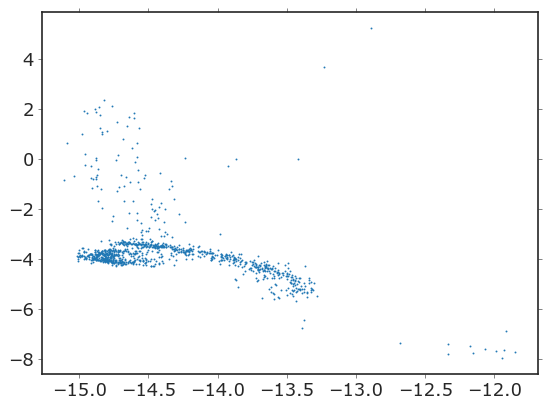

In [5]:
fig, ax=plt.subplots()
ax.scatter(vls0['final'].x.value[-1],vls0['final'].z.value[-1], s=0.5)

In [6]:
t={'t1': 0.*u.Myr, 't2': 1.27*u.Gyr, 'dt':30.*u.Myr}

In [14]:
pot0= gp.CCompositePotential(disk=disk, bulge=bulge, halo=halo)
pot=gp.MilkyWayPotential(units=usys)

In [28]:
pot0.acceleration(pos_tf,t=100*u.Myr)

<Quantity [[-1.37431029e-03],
           [-4.79621642e-05],
           [-3.50962273e-03]] kpc / Myr2>

In [27]:
pot.acceleration(pos_tf,t=100*u.Myr)

<Quantity [[-1.04562727e-03],
           [-3.64914292e-05],
           [-2.66691401e-03]] kpc / Myr2>

In [7]:

def run_collision_in_nbody(C, mhalo, vhalo, halo_r, visualize_collision=False, filename=None,  \
                add_more_stars=False):

    #general configuration
    st_pos= C['stream_coord']
    dt= C['dt']
    tfinal=C['tfinal']
    mstream=C['mstream']
    tcollision=C['tcollision']
    textra=C['textra']
    nsteps=C['nsteps']
    distance_to_hit= C['distance_to_hit']
    filename=C['file_prefix']
    
    #figure out initial position of the stream progenitor
    orbit_tf=gp.Hamiltonian(pot).integrate_orbit(st_pos, dt=-dt, t1=0*u.Gyr, t2=-tfinal)
    pos0=gd.PhaseSpacePosition(pos=orbit_tf.xyz[:,-1], vel=orbit_tf.v_xyz[:,-1])
    
    #generate stream from the begening to the collision
    df = ms.FardalStreamDF()
    gen = ms.MockStreamGenerator(df, H)
    mock_st, mock_pos=gen.run(pos0, mstream, dt=dt, t1=0*u.Myr,  n_particles=50, t2=tcollision)
    
    #figure out positOon to hit
    col_pos=get_collision_pos(mock_st, mock_pos, distance_to_hit)
    
    #run collision
    point_potential=gp.PlummerPotential(mhalo*u.Msun,  halo_r*u.pc, units=usys)
    time_dict={'t1': -textra, 't2': textra, 'nsteps': nsteps}
    evolved=evolve_stream_with_subhalo_orbits_only(mock_st, col_pos, point_potential, time_dict)
    
    #integrate the rest of the orbit
    time_dict_total={'t1': 0*u.Myr, 't2': tfinal-(tcollision+textra), 'dt': dt}
    stream=evolved[-1][:-1]
    evolved_f=evolve_orbits_only_as_null(gd.PhaseSpacePosition(pos=stream.xyz, vel=stream.v_xyz), time_dict)
    

    return  {'tcollision':  mock_st,
            'final': evolved_f}
